# PRAD : Cox-regression with elastic net regularization

# Introduction

The purpose of this workflow is to introduce the KM based feature selection followed by regularised cox regression analysis using ENET. 

# Preparing workspace

In [1]:
setwd("/home/data/project_code/landstrom_core/prognostic_model_development/r/notebooks")

library(ggplot2)
library(tidyverse)
library(survival)
library(survminer)
library(glmnet)
library(WriteXLS)
library(ggfortify)
library(circlize)
library(ComplexHeatmap)
library(parallel)
library(broom)
library(survcomp)
library(survivalROC)
source("../getTCGAData.R")
source("../preprocessTCGAData.R")
source("../KM_analysis.R")
source("../Heatmaps.R")
source("../enet.R")

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-4

circlize 

# Setting up paths and clinical variables

In [2]:
# Define the cancer type 
cancer.type = "PRAD"

In [3]:
# Read in the table including the clinical features for each cancer type
clin.feat.tb = read.table("/workstation/project_data/landstrom_core/clin_features_final.csv", sep = "\t", header = T)

# Get Clinical variables
clin.var = unlist(strsplit(clin.feat.tb$Features[clin.feat.tb$Ctype == cancer.type], split = ","))

# Ensembl id mapping file 
ens.id.mapping = "/home/organisms/Human/hg38/Homo_sapiens.GRCh38_March2022/ENSEMBLE_to_SYMBOL.csv"

# Output dir 
out.dir.data = file.path("/workstation/project_data/landstrom_core/rdata/manuscript_work/", cancer.type)
dir.create(out.dir.data, recursive = T)

Warning message in dir.create(out.dir.data, recursive = T):
“'/workstation/project_data/landstrom_core/rdata/manuscript_work//PRAD' already exists”


In [4]:
clin.var

[1] "Age"           "Gleason.group"

# 1. Read in data 

Read in data using dedicated functions. Only parameter is the cancer code (Abbreviation) which can be 
found [here](https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tcga-study-abbreviations)

Read in copy-number data 

In [5]:
tcga.cn = getTCGACopyNumberData(cancer.type)

Read in gene expression data   

In [6]:
tcga.expr = getTCGAExpressionData(cancer.type, annotation.file = ens.id.mapping)

Read in clinical data 

In [7]:
# Get cancer specific clinical data 
tcga.clin = getClinData(cancer.type)

# Get the end point related clinical data 
tcga.endpoints = getClinEndpointData(cancer.type) %>% dplyr::select(bcr_patient_barcode, OS, OS.time, DSS, DSS.time, DFI, DFI.time, PFI, PFI.time)

# Merge end point data to clinical data 
tcga.clin = dplyr::left_join(tcga.clin, tcga.endpoints, by = "bcr_patient_barcode")

write.csv(tcga.clin, file.path(out.dir.data, "clinical_data.csv"))

# 2. Preprocessing of the data

## 2.1 Copy number data

Keep only primary tumor samples 

In [8]:
tcga.cn = selectPrimaryT(tcga.cn)

Drop out duplicate samples 

In [9]:
tcga.cn = dropDuplicateSamples(tcga.cn)

Prepare data matrix: 

In [10]:
tcga.cn.datamat = prepareDataMatrix(tcga.cn)
saveRDS(tcga.cn.datamat, file = file.path(out.dir.data, "copy_number_status.rds"))

## 2.2 Gene expression data 

Variance stabilizing transformation of the data was performed as suggested by the DESeq2 developers. 

In [11]:
# Store the raw data for future purposes 
tcga.expr$Raw = tcga.expr$Data

# Perform variance stabilising transformation (VST)
tcga.expr$Data = performVST(tcga.expr$Data)

converting counts to integer mode



Keep only the primary tumors 

In [12]:
tcga.expr = selectPrimaryT(tcga.expr)

Drop duplicate samples 

In [13]:
tcga.expr = dropDuplicateSamples(tcga.expr)

Finally we prepare a data matrix

In [14]:
tcga.expr.raw.datamat = prepareDataMatrixRaw(tcga.expr)
tcga.expr.datamat = prepareDataMatrix(tcga.expr)

In [15]:
saveRDS(tcga.expr.raw.datamat, 
        file = file.path(out.dir.data, "raw_expressions.rds"))

## 2.3 Merging all data 

Merge all the different data types together. Takes the clinical data as 
a separate argument and the sequencing data as a list of data matrices.
Suffixes are added based on user given vector which correspond to the 
order in which datamatrices are in the data list.

In [16]:
tcga.dataset = mergeTCGAdata(clin.data = tcga.clin,
                                  data = list(tcga.cn.datamat, 
                                              tcga.expr.datamat), 
                                  data.suffixes = c("cn","exp"))

In [17]:
saveRDS(tcga.dataset, file = file.path(out.dir.data, "tcga.dataset.rds"))

# 3. KM based univariate feature selection

We will now perform the univariate feature selection which is the first phase of 
the actual analysis. The idea is to prefilter some features which have no predictive 
power regarding survival. We will select one clinical end point which seems to carry 
most events to maximise the statistical power. 

## 3.1 Loading data and selection of variables 

Load the dataset if needed

In [18]:
# Read in the preprocessed dataset if continued 
tcga.dataset = readRDS(file.path(out.dir.data, "tcga.dataset.rds"))

# Raw expression data 
tcga.expr.raw.datamat = readRDS(file.path(out.dir.data, "raw_expressions.rds"))

Define and create output directories 

In [19]:
# Define and create the root directory for results 
dir.res.root = file.path("/workstation/project_results/landstrom_core/prognostic_model_development/models_by_cancer_type/", cancer.type)
dir.create(dir.res.root, recursive = T)

# Define and create the results for the KM analysis 
dir.res.km = file.path(dir.res.root, "Kaplan_Meier_plots")
dir.create(dir.res.km)

Read in the gene list of interest including the customer genes

In [20]:
# Gene list  
gene.list.file = read.table("/workstation/project_data/landstrom_core/Customer_genes.tsv", 
                            sep = "\t", header = F)
gene.list = gene.list.file$V1

Tabulate the number of events. Value 0 means sensored and value 1 an event.

In [21]:
clinical.end.point.stats = tcga.dataset %>% 
                                   dplyr::select(c("OS.clin","DSS.clin","DFI.clin","PFI.clin")) %>%
                                   pivot_longer(everything()) %>%
                                   mutate(value = factor(value)) %>%
                                   group_by(name, value) %>%
                                   summarise(N = n()) %>% 
                                   pivot_wider(names_from =  value,
                                               values_from = N)

`summarise()` has grouped output by 'name'. You can override using the `.groups` argument.


In [22]:
clinical.end.point.stats

name,0,1,NA
<chr>,<int>,<int>,<int>
DFI.clin,310,30,160
DSS.clin,493,5,2
OS.clin,490,10,NA
PFI.clin,407,93,NA


## 3.2 Splitting dataset into training and validation set

Here we change the original workflow such that we run the analysis for all clinical end points.

In [23]:
# Here we store all the training and validation splits 
train_and_validation_ls = list()

# Variables selected 
variables_selected_ls = list()

# Number of samples in training and validation cohorts 
nsamples_step1_ls = list()

In [24]:
for (end.point in c("OS","DSS","DFI","PFI")){

    # Selected variables 
    variables.selected = selectVariables(clinical.endpoint = end.point, 
                                     gene.list = gene.list, 
                                     data.suffixes = c("cn","exp"))
    variables_selected_ls[[end.point]] = variables.selected
    
    #Data set is split randomly into training and validation sets. Only complete cases 
    # are selected.
    train_and_validation = splitCases(data = tcga.dataset, 
                                  split = 0.75, 
                                  only.complete = T,
                                  variables = variables.selected, 
                                  seed = 42)
    
    # Update list
    train_and_validation_ls[[end.point]] = train_and_validation 
    
    
    # Store number of  
    nsamples.step1 = c(nrow(train_and_validation$train), nrow(train_and_validation$validation))
    names(nsamples.step1) = c("ntrain.step1", "nvalid.step1")
    nsamples_step1_ls[[end.point]] = nsamples.step1
}

[1] "Taking only complete cases"
[1] "Including 492 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 491 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 336 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 492 cases out of 500 cases"


## 3.3 Filtering step 

### 3.3.1 Calculate relevant statistics for the training set. 

We will calculate the following statistics for expression features based on the raw expression data : 
1. The fraction of individuals expressing the feature  
2. Median expression of the feature
3. Variance of the feature

We will calculate the following statistics for copy number features 
1. Fraction of individuals with amplification 
2. Fraction of individuals with deletion
3. Fraction of individuals with missing CN status 
4. Max value out of the fraction of individuals with amplification and deletions 

In [25]:
# Store summary statistics 
summary.stats.ls = list()

# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    exp.summary.training = prepSummaryExp(x = train_and_validation$train, 
                                      raw.data = tcga.expr.raw.datamat,
                                      variables = variables.selected, type = "exp")

    cn.summary.training = prepSummaryCN(train_and_validation$train, variables = variables.selected, type = "cn")
    
    summary.stats.ls[[end.point]] = list("exp.summary.training" = exp.summary.training,
                                         "cn.summary.training" = cn.summary.training)
}


### 3.3.2 Filter based on the calculated statistics

We will set the filtering thresholds as follows : 

Expression features : 

1. Median expression must be greater than 20
2. Fraction of individuals expressing feature must be greater than > 0.25

CN features 

1. Maximum Fraction of individuals carrying either deletion or amplification must be at least 0.15


In [26]:
# Store filtered variables 
variables.selected.filtered.ls = list()

# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){

    exp.features.keep = summary.stats.ls[[end.point]]$exp.summary.training %>% 
                          filter(`Median expression` > 20, 
                                 `Fraction of zero expression` < 0.75)

    cn.features.keep = summary.stats.ls[[end.point]]$cn.summary.training %>% 
                          filter(`Maximum fraction of aberrations` > 0.15) 

    # Update the summary tables 
    summary.stats.ls[[end.point]]$exp.summary.training$Selected = ifelse(summary.stats.ls[[end.point]]$exp.summary.training$name %in% exp.features.keep$name, "Yes", "No")
    summary.stats.ls[[end.point]]$cn.summary.training$Selected = ifelse(summary.stats.ls[[end.point]]$cn.summary.training$name %in% cn.features.keep$name, "Yes", "No")

    # Collect the variables into vector 
    variables.selected.filtered.ls[[end.point]] = filterFeatures(variables_selected_ls[[end.point]], exp.features.keep$name, type = "exp")
    variables.selected.filtered.ls[[end.point]]= filterFeatures(variables_selected_ls[[end.point]], cn.features.keep$name, type = "cn")
    
}

Final list of features

## 3.4 Prepare univariate KM plots and logrank tests

In [27]:
# Store the KM tables 
km.pvalue.table.ls = list()

# Store the significant features 
significant.features.ls = list()

# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){

    # Create dir for plots 
    dir.create(file.path(dir.res.km, end.point))
    
    if (nrow(train_and_validation_ls[[end.point]]$train) > 0){
    
        # Run univariate KM
        km.pvalue.table = runUnivariateKM(input.data = train_and_validation_ls[[end.point]], 
                                  variables = variables.selected.filtered.ls[[end.point]],
                                  clinical.endpoint = end.point,
                                  out.dir = file.path(dir.res.km, end.point),
                                  plots = T)
    
    
        # Sort the results based on the training p-value and write the results to output
        km.pvalue.table = km.pvalue.table %>% dplyr::arrange(pvalues.training)
        km.pvalue.table$Selected = ifelse(km.pvalue.table$pvalues.training < 0.05, "Yes", "No") 
        write.csv(km.pvalue.table, file.path(dir.res.km, paste0(end.point, "_LogRank_pvalues.csv")))
    
        km.pvalue.table.ls[[end.point]] = km.pvalue.table
    
        # Extract the significant features 
        significant.features = getSignificantFeatures(km.pvalue.table, pvalue.thresh = 0.05)

        # Store 
        significant.features.ls[[end.point]] = significant.features
        
    } else {
        significant.features.ls[[end.point]] = NULL
    }
}

NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL
NULL


# 4 Penalised cox regression without clinical variables 

Define path to output 

In [28]:
dir.res.pcox = file.path(dir.res.root, "Penalized_Cox_risk_prediction/customer_features/Without_clinical_features")
dir.create(dir.res.pcox, recursive = T)

In [29]:
# Helper function for fixing variable names 
fixVarNames = function(x){
    if (str_detect(x, "Gender")) {
        return("Gender")
    } else if (str_detect(x, "Tumor.stage")){
        return("Tumor.stage")
    } else if (str_detect(x,".cn")){
        return(str_extract(x, "\\w+.cn"))
    } else if (str_detect(x, "Gleason.group")){ 
        return("Gleason.group")
    } else {
        return(x)
    }
}

## 4.1 Splitting dataset into training and validation set

In [30]:
# Here we store all the training and validation splits 
train_and_validation_ls = list()

# Number of samples in training and validation cohorts 
nsamples_step2_ls_no_clin = list()

In [31]:
# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    # We will first combine the significant.features with the outcome variables
    # Final list of features 
    feature.ls = c(paste0(end.point, c(".clin",".time.clin")), significant.features.ls[[end.point]])
    
    if (is.null(significant.features.ls[[end.point]]) == F) {
    
        # Now we split the dataset into training and validation cohorts exactly as before.
        train_and_validation = splitCases(data = tcga.dataset, 
                                  split = 0.75, 
                                  only.complete = T,
                                  variables = feature.ls,
                                  seed = 42)
    
        # Store 
        train_and_validation_ls[[end.point]] = train_and_validation
    
        # Store the number of samples       
        nsamples.step2 = c(nrow(train_and_validation$train), nrow(train_and_validation$validation))
    }    
    else {
    
        # If there are now significant features store NULL
        
        # Store 
        train_and_validation_ls[[end.point]] = NULL
        nsamples.step2 = c(NA, NA)
    }
        
    names(nsamples.step2) = c("ntrain.step2", "nvalid.step2")
    nsamples_step2_ls_no_clin[[end.point]] = nsamples.step2
}

[1] "Taking only complete cases"
[1] "Including 493 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 337 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 492 cases out of 500 cases"


## 4.2 Find the optimal lambda 

Use 10-fold cross-validation (CV) for the Cox model for different values of lamda. C-index will be use to evaluate the models.

In [32]:
# Store significant features 
rcox.res.no.clin.ls = list()

# Store model matrices
model.matrices.ls = list()

# Store the fitted models for prediction 
pcox.fit.ls = list()

In [33]:
# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    # Check the number of features
    # Regulariation cannot be run if there is only one feature
    num.feat = ncol(train_and_validation_ls[[end.point]]$train) - 2
    
    if (is.null(train_and_validation_ls[[end.point]]$train) == F){
        if (num.feat > 1) {
    
            # Genereate model matrix 
            model.matrices = generateModelMatrices(train_and_validation_ls[[end.point]]$train, 
                             train_and_validation_ls[[end.point]]$validation, 
                             clinical.endpoint = end.point)
        
            model.matrices.ls[[end.point]] = model.matrices
    
            # Create output dir 
            dir.create(file.path(dir.res.pcox, end.point))
    
            # Find optimal lambda (hyperparameter for elastic net)
            pcox.fit = findOptimalLambda(x = model.matrices$x.train.mat, 
                             y = model.matrices$y.train,
                             out.dir = file.path(dir.res.pcox, end.point))
        
            pcox.fit.ls[[end.point]] = pcox.fit
    
            # Write the final features included in the model to a file 
            WriteXLS(pcox.fit$active.k.vals, 
             file.path(dir.res.pcox, end.point ,"Active_covariates_in_lambda.min_model.xlsx"), 
             BoldHeaderRow = T,
             row.names = T)
    
            # Final significant features 
            rcox.res.no.clin = pcox.fit$active.k.vals %>% tibble::rownames_to_column("Feature")
            rcox.res.no.clin.ls[[end.point]] = rcox.res.no.clin  
        } else {
            # If no significant features from earlier steps for the clin. end point then store null
            model.matrices.ls[[end.point]] = NULL
            pcox.fit.ls[[end.point]] = NULL
            rcox.res.no.clin.ls[[end.point]] = NULL
        }

    } else {
        # If no significant features from earlier steps for the clin. end point then store null
        model.matrices.ls[[end.point]] = NULL
        pcox.fit.ls[[end.point]] = NULL
        rcox.res.no.clin.ls[[end.point]] = NULL
    }
}

## 4.3 Make predictions using the cross-validated model and heatmaps for visualisation

## 4.3.1 Training set 

In [34]:
# Store the result tables
KM.train.by.risk.ls = list()

In [35]:
# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    if (!is.null(pcox.fit.ls[[end.point]])) {
    
        # Predictions for the training set
        pred.train <- predict(pcox.fit.ls[[end.point]]$model, 
                      newx = model.matrices.ls[[end.point]]$x.train.mat, 
                      s = "lambda.min", 
                      type = "response")

        # Fitted relative risk
        rel.risk <- pred.train[,1] 

        # Stratify validation data into two groups based on the fitted relative risk
        y.data <- as.data.frame(as.matrix(model.matrices.ls[[end.point]]$y.train))
        
        
        # Plot KM and extract the p-value  
        KM.train.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                        rel.risk = rel.risk)
        
        if (!is.null(KM.train.by.risk)) {
        
            # Store
            KM.train.by.risk.ls[[end.point]] =  KM.train.by.risk$table
    
            # Store the KM plot
            pdf(file.path(dir.res.pcox, end.point ,"glmnet_K-M_plot_with_training_data.pdf"), 
                width = 15, height = 12, onefile = F)
            print(KM.train.by.risk$Plot)
            dev.off()
    
            # Heatmap preparation         
    
            # Variables to be selected 
            # Because Gender has been changed to a dummy variable its name has been changed
            variables.selected = map_chr(rcox.res.no.clin.ls[[end.point]]$Feature, fixVarNames)
    
            # Get all input variables
            heatmap.input.train = model.matrices.ls[[end.point]]$x.train %>% dplyr::select(all_of(variables.selected))
    
            # Heatmap of training data predictions
            hmap.train <- prepareHeatmap(heatmap.input.train, y.data, pred.train, file.path(dir.res.pcox, end.point), "glmnet_training", row.height = 8) 
        
        } else {
            KM.train.by.risk.ls[[end.point]] = NULL
        }
        
    } else {
        KM.train.by.risk.ls[[end.point]] = NULL
    }
}

## 4.3.2 Validation set

In [36]:
# Store the result tables
KM.valid.by.risk.ls = list()

In [37]:
# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    if (!is.null(pcox.fit.ls[[end.point]])) {
    
        # Predictions for the training set
        pred.valid <- predict(pcox.fit.ls[[end.point]]$model, 
                      newx = model.matrices.ls[[end.point]]$x.valid.mat, 
                      s = "lambda.min", 
                      type = "response")

        # Fitted relative risk
        rel.risk <- pred.valid[,1] 

        # Stratify validation data into two groups based on the fitted relative risk
        y.data <- as.data.frame(as.matrix(model.matrices.ls[[end.point]]$y.valid))

        # Plot KM and extract the p-value  
        KM.valid.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                        rel.risk = rel.risk)
        
        if (!is.null(KM.train.by.risk)) {
        
            # Store
            KM.valid.by.risk.ls[[end.point]] =  KM.valid.by.risk$table
    
            # Store the KM plot
            pdf(file.path(dir.res.pcox, end.point ,"glmnet_K-M_plot_with_validation_data.pdf"), 
            width = 15, height = 12, onefile = F)
            print(KM.valid.by.risk$Plot)
            dev.off()
    
            # Heatmap preparation 
    
            # Variables to be selected 
            variables.selected = map_chr(rcox.res.no.clin.ls[[end.point]]$Feature, fixVarNames) 
    
            # Get all input variables
            heatmap.input.valid = model.matrices.ls[[end.point]]$x.valid %>% dplyr::select(all_of(variables.selected))
    
            # Heatmap of training data predictions
            hmap.valid <- prepareHeatmap(heatmap.input.valid, y.data, pred.valid, file.path(dir.res.pcox, end.point), "glmnet_validation", row.height = 8)  
        
        } else {
            KM.valid.by.risk.ls[[end.point]] = NULL
        }
        
    } else {
        KM.valid.by.risk.ls[[end.point]] = NULL
    }
}

Merge the two result tables into one 

In [38]:
KM.by.risk.no.clin.train = bind_rows(KM.train.by.risk.ls, .id = "End point")
KM.by.risk.no.clin.valid = bind_rows(KM.valid.by.risk.ls, .id = "End point")

In [39]:
# Store final resilts
write.csv(KM.by.risk.no.clin.train, file.path(dir.res.pcox, "Final_evaluation_results_training.csv"), row.names = F)
write.csv(KM.by.risk.no.clin.valid, file.path(dir.res.pcox, "Final_evaluation_results_validation.csv"),row.names = F)

# 5 Penalised cox regression with clinical variables

In the case of PRAD we will use Age and Gender.

Define path to output 

In [40]:
dir.res.pcox = file.path(dir.res.root, "Penalized_Cox_risk_prediction/customer_features/With_clinical_features")
dir.create(dir.res.pcox, recursive = T)

## 5.1 Preprocess clinical variables

In [41]:
# Define function for adding the clinical variables 
addClinVar = function(data, clin.var) {
    if ("Age" %in% clin.var) {
        data$Age <- data$age_at_diagnosis.clin
    } 
    if ("Tumor.stage" %in% clin.var){
        data$Tumor.stage = factor(map_chr(data$ajcc_pathologic_stage.clin, reformatTumorStage))
    }
    if ("Gender" %in% clin.var){
        data$Gender <- factor(data$gender.clin)    
    } 
    if ("Gleason.group" %in% clin.var) {
        
        # Determine the Gleason group 
        data$Gleason.group = map2_chr(data$primary_gleason_grade.clin, 
                                           data$secondary_gleason_grade.clin, 
                                           determineGleasonGroup)

        # Set up the factor levels 
        data$Gleason.group = factor(data$Gleason.group, 
                                    levels = c("Gleason group 1", "Gleason group 2"))
    }
    return(data)
}

In [42]:
# Add clinical variables to dataset
tcga.dataset = addClinVar(tcga.dataset, clin.var)

## 5.2 Splitting dataset into training and validation set

Generate the final feature ls 

In [43]:
# Here we store all the training and validation splits 
train_and_validation_ls = list()

# Number of samples in training and validation cohorts 
nsamples_step2_ls_with_clin = list()

In [44]:
for (end.point in c("OS","DSS","DFI","PFI")){
    
    # We will first combine the significant.features with the outcome variables
    # Final list of features 
    feature.ls = c(paste0(end.point, c(".clin",".time.clin")), clin.var, significant.features.ls[[end.point]])
   
    if (is.null(significant.features.ls[[end.point]]) == F) {
    
        # Now we split the dataset into training and validation cohorts exactly as before.
        train_and_validation = splitCases(data = tcga.dataset, 
                                  split = 0.75, 
                                  only.complete = T,
                                  variables = feature.ls,
                                  seed = 42)
    
        # Store 
        train_and_validation_ls[[end.point]] = train_and_validation   
        nsamples.step2 = c(nrow(train_and_validation$train), 
                           nrow(train_and_validation$validation))
    }    
    else {
    
        # If there are now significant features store NULL
        
        # Store 
        train_and_validation_ls[[end.point]] = NULL
        nsamples.step2 = c(NA, NA)
    }
        
    names(nsamples.step2) = c("ntrain.step2", "nvalid.step2")
    nsamples_step2_ls_with_clin[[end.point]] = nsamples.step2
}

[1] "Taking only complete cases"
[1] "Including 482 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 331 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 481 cases out of 500 cases"


## 5.3 Find the optimal lambda 

Use 10-fold cross-validation (CV) for the Cox model for different values of lamda. C-index will be use to evaluate the models.

In [45]:
# Store significant features 
rcox.res.with.clin.ls = list()

# Store model matrices
model.matrices.ls = list()

# Store the fitted models for prediction 
pcox.fit.ls = list()

In [46]:
# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    # Check the number of features
    # Regulariation cannot be run if there is only one feature
    num.feat = ncol(train_and_validation_ls[[end.point]]$train) - 2
    
    if (is.null(train_and_validation_ls[[end.point]]$train) == F){
        if (num.feat > 1) {
    
            # Genereate model matrix 
            model.matrices = generateModelMatrices(train_and_validation_ls[[end.point]]$train, 
                             train_and_validation_ls[[end.point]]$validation, 
                             clinical.endpoint = end.point)
        
            model.matrices.ls[[end.point]] = model.matrices
    
            # Create output dir 
            dir.create(file.path(dir.res.pcox, end.point))
    
            # Find optimal lambda (hyperparameter for elastic net)
            pcox.fit = findOptimalLambda(x = model.matrices$x.train.mat, 
                             y = model.matrices$y.train,
                             out.dir = file.path(dir.res.pcox, end.point))
        
            pcox.fit.ls[[end.point]] = pcox.fit
    
            # Write the final features included in the model to a file 
            WriteXLS(pcox.fit$active.k.vals, 
             file.path(dir.res.pcox, end.point ,"Active_covariates_in_lambda.min_model.xlsx"), 
             BoldHeaderRow = T,
             row.names = T)
    
            # Final significant features 
            rcox.res.with.clin = pcox.fit$active.k.vals %>% tibble::rownames_to_column("Feature")
            rcox.res.with.clin.ls[[end.point]] = rcox.res.with.clin  
            
        } else {
            # If no significant features from earlier steps for the clin. end point then store null
            model.matrices.ls[[end.point]] = NULL
            pcox.fit.ls[[end.point]] = NULL
            rcox.res.with.clin.ls[[end.point]] = NULL
        }

    } else {
        # If no significant features from earlier steps for the clin. end point then store null
        model.matrices.ls[[end.point]] = NULL
        pcox.fit.ls[[end.point]] = NULL
        rcox.res.with.clin.ls[[end.point]] = NULL
    }
}

## 5.4 Make predictions using the cross-validated model

## 5.4.1 Training set 

In [47]:
# Store the result tables
KM.train.by.risk.ls = list()
C.index.train.ls = list()
AUC.train.ls = list()

In [48]:
# Helper function for fixing variable names 
fixVarNames = function(x){
    if (str_detect(x, "Gender")) {
        return("Gender")
    } else if (str_detect(x, "Tumor.stage")){
        return("Tumor.stage")
    } else if (str_detect(x,".cn")){
        return(str_extract(x, "\\w+.cn"))
    } else if (str_detect(x, "Gleason.group")){ 
        return("Gleason.group")
    } else {
        return(x)
    }
}

In [49]:
# Calculate AUC
calcAUC = function(pred.time, time, status, risk.score){
    
    # Calculate ROC characteristics
    res.ROC = survivalROC(Stime = time,
                          status = status,
                          marker = risk.score,
                          predict.time = pred.time,
                          method  = "KM")
    return(min(res.ROC$AUC,1))
}

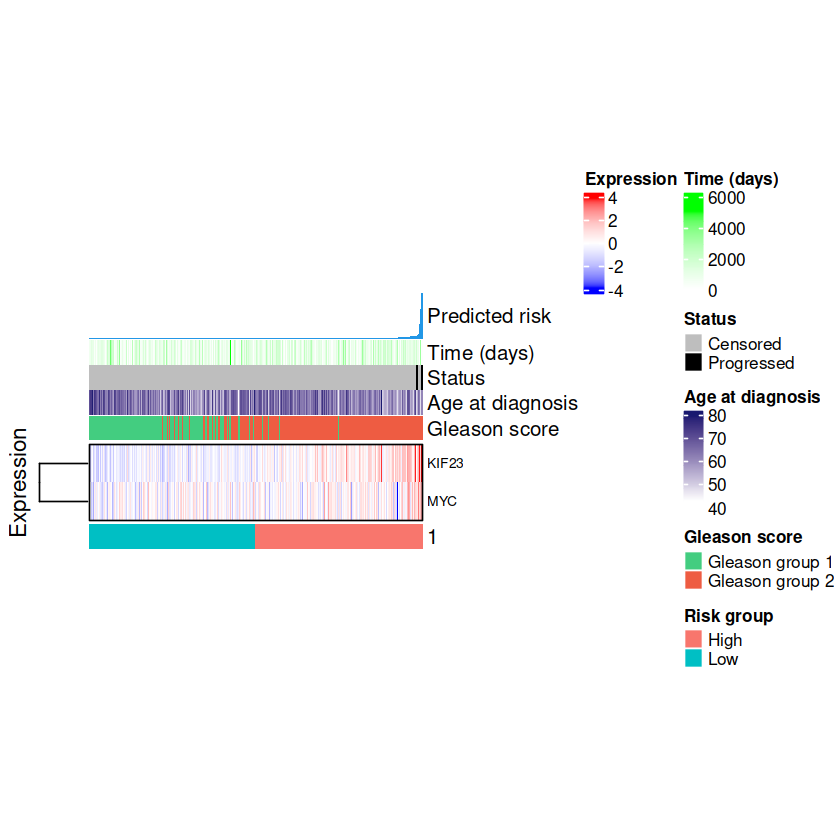

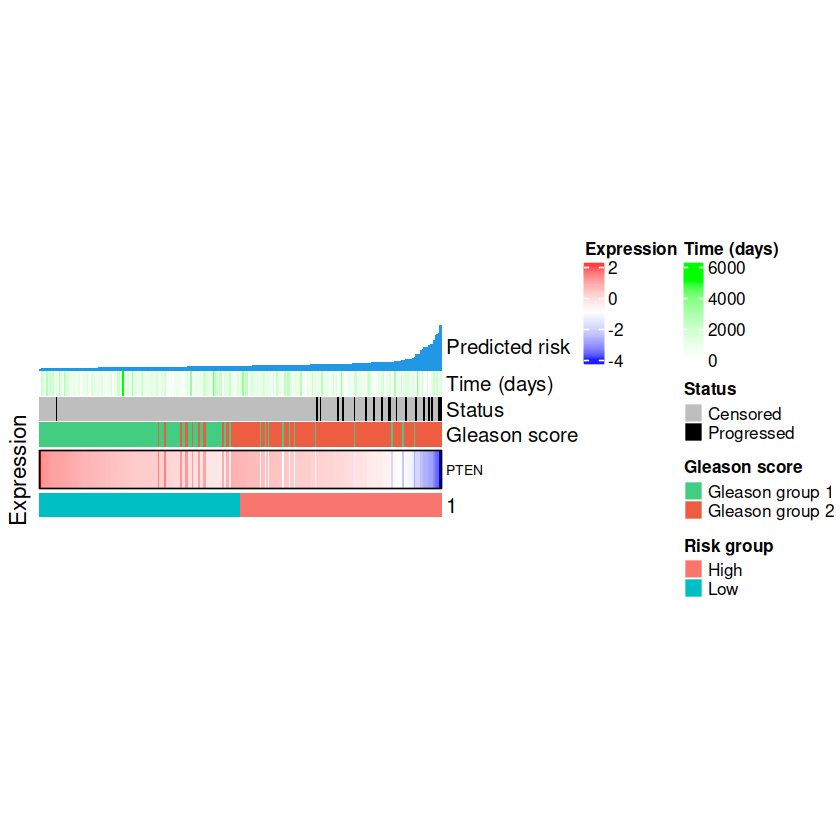

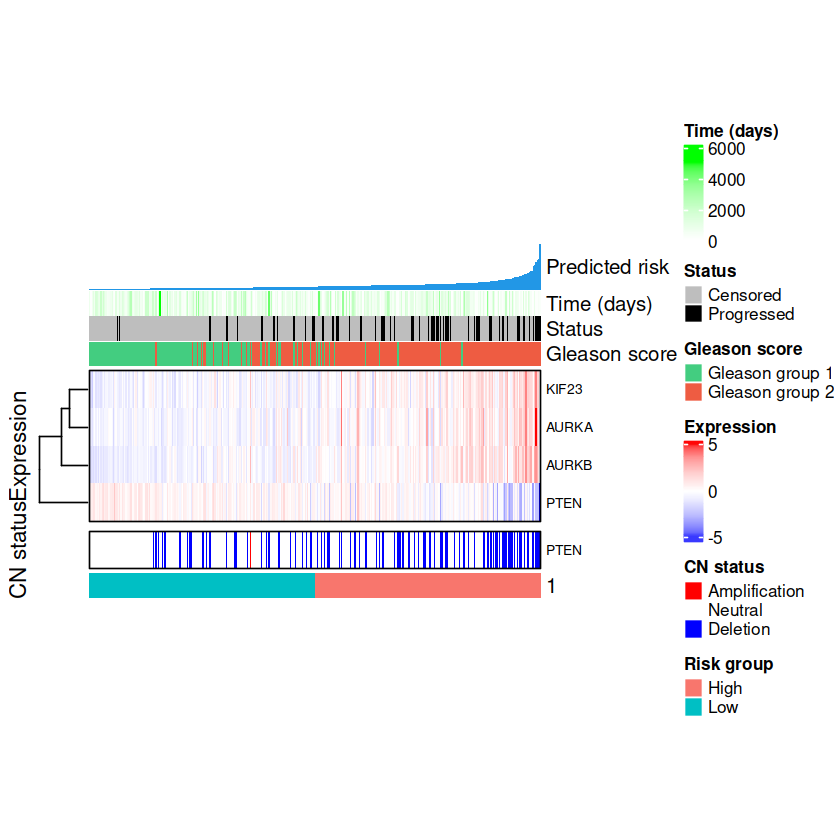

In [50]:
# Set seed 
set.seed(42)

# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    if (!is.null(pcox.fit.ls[[end.point]])) {
    
        # Predictions for the training set
        pred.train <- predict(pcox.fit.ls[[end.point]]$model, 
                      newx = model.matrices.ls[[end.point]]$x.train.mat, 
                      s = "lambda.min", 
                      type = "response")

        # Fitted relative risk
        rel.risk <- pred.train[,1] 
        
        # Calculate the C-index (NEW ADDITION )
        c.index.train = Cindex(pred = pred.train, y = model.matrices.ls[[end.point]]$y.train) 
        C.index.train.ls[[end.point]] = c.index.train 

        # Stratify validation data into two groups based on the fitted relative risk
        y.data <- as.data.frame(as.matrix(model.matrices.ls[[end.point]]$y.train))
        
        
        # TEST new function for calculating the C-index
        cindex.train = concordance.index(rel.risk, 
                                         y.data$time, 
                                         y.data$status,
                                         na.rm = TRUE)
        
        C.index.train.ls[[end.point]] = data.frame("C-index" = round(cindex.train$c.index, 4),
                                          "C-index CI" = paste0("(", round(cindex.train$lower, 4), " - ",  
                                                                round(cindex.train$upper, 4), ")"),
                                        check.names = F)
        

        # Plot KM and extract the p-value  
        KM.train.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                        rel.risk = rel.risk)
        
        
        # Calculate AUCs 
        auc.vect = round(map_dbl(c(365, 3 * 365, 5 * 365), .f = calcAUC, 
                   time = y.data$time, status = y.data$status , risk.score = rel.risk), 4)
        names(auc.vect) = c("AUC (1y)", "AUC (3y)", "AUC (5y)")
        
        AUC.train.ls[[end.point]] = as.data.frame(t(data.frame(auc.vect)))
    
        if (!is.null(KM.train.by.risk)) {
        
            # Store
            KM.train.by.risk.ls[[end.point]] =  KM.train.by.risk$table
    
            # Store the KM plot
            pdf(file.path(dir.res.pcox, end.point ,"glmnet_K-M_plot_with_training_data.pdf"), 
                width = 15, height = 12, onefile = F)
            print(KM.train.by.risk$Plot)
            dev.off()
    
            # Heatmap preparation 
    
            # Variables to be selected 
            # Because Gender has been changed to a dummy variable its name has been changed
            variables.selected = map_chr(rcox.res.with.clin.ls[[end.point]]$Feature, fixVarNames)
    
            # Get all input variables
            heatmap.input.train = model.matrices.ls[[end.point]]$x.train %>% dplyr::select(all_of(variables.selected))
    
            # Heatmap of training data predictions
            hmap.train <- prepareHeatmap(heatmap.input.train, y.data, pred.train, file.path(dir.res.pcox, end.point), "glmnet_training", row.height = 8)
            print(hmap.train)
            
        } else {
            KM.train.by.risk.ls[[end.point]] = NULL
            C.index.train.ls[[end.point]] = NULL
            AUC.train.ls[[end.point]] = NULL
            
        }
    } else {
        KM.train.by.risk.ls[[end.point]] = NULL
        C.index.train.ls[[end.point]] = NULL
        AUC.train.ls[[end.point]] = NULL
    }
}

## 5.4.2 Validation set

In [51]:
# Store the result tables
KM.valid.by.risk.ls = list()
C.index.valid.ls = list()
AUC.valid.ls = list()

In [52]:
# Set seed
set.seed(42)

# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){
    
    if (!is.null(pcox.fit.ls[[end.point]])) {
    
        # Predictions for the validation set
        pred.valid <- predict(pcox.fit.ls[[end.point]]$model, 
                      newx = model.matrices.ls[[end.point]]$x.valid.mat, 
                      s = "lambda.min", 
                      type = "response")

        # Fitted relative risk
        rel.risk <- pred.valid[,1] 

        # Stratify validation data into two groups based on the fitted relative risk
        y.data <- as.data.frame(as.matrix(model.matrices.ls[[end.point]]$y.valid))
        
        
        # TEST new function for calculating the C-index
        cindex.valid = concordance.index(rel.risk, 
                                         y.data$time, 
                                         y.data$status,
                                         na.rm = TRUE)
        
        C.index.valid.ls[[end.point]] = data.frame("C-index" = round(cindex.valid$c.index, 4),
                                          "C-index CI" = paste0("(", round(cindex.valid$lower, 4), " - ",  
                                                                round(cindex.valid$upper, 4), ")"),
                                        check.names = F)
        
        # Plot KM and extract the p-value  
        KM.valid.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                        rel.risk = rel.risk)
        
        # Calculate AUCs 
        auc.vect = round(map_dbl(c(365, 3 * 365, 5 * 365), .f = calcAUC, 
                   time = y.data$time, status = y.data$status , risk.score = rel.risk),4)
        
        names(auc.vect) = c("AUC (1y)", "AUC (3y)", "AUC (5y)")
        
        AUC.valid.ls[[end.point]] = as.data.frame(t(data.frame(auc.vect)))
    
        if (!is.null(KM.train.by.risk)) {
            
            # Store
            KM.valid.by.risk.ls[[end.point]] =  KM.valid.by.risk$table
    
            # Store the KM plot
            pdf(file.path(dir.res.pcox, end.point ,"glmnet_K-M_plot_with_validation_data.pdf"), 
                width = 15, height = 12, onefile = F)
            print(KM.valid.by.risk$Plot)
            dev.off()
    
            # Heatmap preparation 
    
            # Variables to be selected 
            variables.selected = map_chr(rcox.res.with.clin.ls[[end.point]]$Feature, fixVarNames)
    
            # Get all input variables
            heatmap.input.valid = model.matrices.ls[[end.point]]$x.valid %>% dplyr::select(all_of(variables.selected))
    
            # Heatmap of training data predictions
            hmap.valid <- prepareHeatmap(heatmap.input.valid, y.data, pred.valid, file.path(dir.res.pcox, end.point), "glmnet_validation", row.height = 8)
            
        } else {
            KM.valid.by.risk.ls[[end.point]] = NULL
            C.index.valid.ls[[end.point]] = NULL
            AUC.valid.ls[[end.point]] = NULL
        }
    } else {
        KM.valid.by.risk.ls[[end.point]] = NULL
        C.index.valid.ls[[end.point]] = NULL
        AUC.valid.ls[[end.point]] = NULL
    }
}

In [53]:
# Collect the results into a single data frame

# Log-rank test results 
KM.by.risk.with.clin.train = bind_rows(KM.train.by.risk.ls, .id = "End point")
KM.by.risk.with.clin.valid = bind_rows(KM.valid.by.risk.ls, .id = "End point")

# C-indices
C.index.train.df = bind_rows(C.index.train.ls , .id = "End point")
C.index.valid.df = bind_rows(C.index.valid.ls , .id = "End point")

# AUCs 
auc.train.df = bind_rows(AUC.train.ls, .id  = "End point") 
auc.valid.df = bind_rows(AUC.valid.ls, .id  = "End point")

In [54]:
# Store final resilts
write.csv(KM.by.risk.with.clin.train, file.path(dir.res.pcox, "Final_evaluation_results_training.csv"), row.names = F)
write.csv(KM.by.risk.with.clin.valid, file.path(dir.res.pcox, "Final_evaluation_results_validation.csv"),row.names = F)

write.csv(C.index.train.df, file.path(dir.res.pcox, "Final_evaluation_C_index_training.csv"), row.names = F)
write.csv(C.index.valid.df, file.path(dir.res.pcox, "Final_evaluation_C_index_validation.csv"), row.names = F)

write.csv(auc.train.df, file.path(dir.res.pcox, "Final_evaluation_AUC_training.csv"), row.names = F)
write.csv(auc.valid.df, file.path(dir.res.pcox, "Final_evaluation_AUC_validation.csv"), row.names = F)

# 6. For each clinical end point produce a reference model including only clinical variables 

Modified heatmap function 

In [55]:
prepareHeatmap_clin = function(feature_data, 
                          surv_data, 
                          predicted.risk, 
                          dir, 
                          name, 
                          row.height = 4){
    

    # Extract survival data
    survivalData = surv_data
  
    # Recode the numberic data into factor
    survivalData <- mutate(survivalData, Event = recodeEvent(status))

    # Extract predicted risk 
    predRisk  = predicted.risk

    # Based on the predicted risk divide the patients into groups 
    group = ifelse(predRisk  < median(predRisk), "Low", "High")
  
    # Color scale for the prediction
    predCol = colorRamp2(c(min(predRisk),max(predRisk)), 
                        c("#00bfc4","#f8766d"))

    # Colorscale for the risk groups
    riskCol = structure(c("#00bfc4","#f8766d"), names = c("Low", "High"))


    # Colorscale for the time variable
    timeCol = colorRamp2(seq(0, max(survivalData$time), length = 2), 
                        c("white", "green"), space = "RGB")
  
    # Colorscale for the status 
    statusCol = structure(c("grey","black"), names = c("Censored","Progressed"))

    # Initialise clinical variables and colorschemes 
    age.at.diag.years = NULL
    gender = NULL
    tumor.stage = NULL
    gleason.score = NULL 
    
    ageCol = NULL
    genderCol = NULL
    tumorStageCol = NULL 
    gleasonCol = NULL

    # Add clinical variables if present 
    if (is.null(feature_data$Age) == F) {
        age.at.diag.years = (feature_data$Age / 360) 
    }

    gender = feature_data$Gender
    tumor.stage = feature_data$Tumor.stage
    gleason.score = feature_data$Gleason.group
 
    # Age colorscheme
    if (is.null(feature_data$Age) == F) {
            ageCol = colorRamp2(c(min(age.at.diag.years),max(age.at.diag.years)), 
                        c("white","midnightblue"))
    }

    # Gender colorscheme
    if (is.null(feature_data$Gender) == F){
        genderCol = structure(c("orange", "brown"), names = c("female","male"))
    }

    # Tumor stage colorscheme
    if (is.null(feature_data$Tumor.stage) == F){
        tumorStageCol = structure(c("grey","steelblue1", "steelblue2",  "steelblue3", "steelblue"),
                                   names = c("NA","Stage 1", "Stage 2", "Stage 3", "Stage 4"))}

    if (is.null(feature_data$Gleason.group) == F) {
            gleasonCol = structure(c("seagreen3","tomato2"), names = c("Gleason group 1","Gleason group 2"))
    }

    # Prepare the heatmap components  

    # Collect varibles into a final data frame 
    heatmap.data = data.frame(`Time (days)` = survivalData$time,
                              Status = survivalData$Event, check.names = F)

    if (is.null(age.at.diag.years) == F) {
            heatmap.data$`Age at diagnosis` = age.at.diag.years
    }
    if (is.null(gender) == F) {
            heatmap.data$`Gender` = gender
    }
    if (is.null(tumor.stage) == F) {
            heatmap.data$`Tumor stage` = tumor.stage
    } 

    if (is.null(gleason.score) == F) {
            heatmap.data$`Gleason score` = gleason.score
    } 

    # Color data for the heatmap
    color.data = list(Status = statusCol,
                      `Time (days)` = timeCol)

    if (is.null(age.at.diag.years) == F) {
        color.data$`Age at diagnosis` = ageCol
    }
    if (is.null(gender) == F) {
        color.data$Gender = genderCol
    }
    if (is.null(tumor.stage) == F) {
        color.data$`Tumor stage` = tumorStageCol
    } 
    if (is.null(gleason.score) == F) {
        color.data$`Gleason score` = gleasonCol
    } 

    
    predRisk.ord = predRisk[order(predRisk)]
    
    # Generate top annotation 
    ha.top.1 = HeatmapAnnotation(`Predicted risk` = anno_barplot(predRisk.ord, 
                                                                 border = F, 
                                                                 axis = F, 
                                                                 bar_width = 1,
                                                  gp = gpar(fill = 4, lwd = 0)))

    
    heatmap.data = heatmap.data[order(predRisk),]
    ha.top.2 = HeatmapAnnotation(df = heatmap.data, 
                           col = color.data)

    # Concatenate 
    ha.top = c(ha.top.1, ha.top.2) 
    
    group = group[order(predRisk)]

    # Bottom annotation
    ha.bottom = HeatmapAnnotation(`Risk group` = group,
                          col = list(`Risk group` = riskCol))
    
    # Combine the heatmaps 
    combHeat = ha.top %v% ha.bottom
            
    pdf(file.path(dir, paste0(name, "_heatmap.pdf")))
        draw(combHeat)
        dev.off()
    return(combHeat)
    
}

In [56]:
dir.res.pcox = file.path(dir.res.root, "Penalized_Cox_risk_prediction/customer_features/Only_clinical_features")
dir.create(dir.res.pcox, recursive = T)

## 6.1 Splitting dataset into training and validation set

In [57]:
# x : training_and_validation data 
# rm : Keep the listed variables
dropFeatures = function(x, rm){
    x$train = dplyr::select(x$train, -all_of(rm))
    x$validation = dplyr::select(x$validation, -all_of(rm))
    return(x)
}

In [58]:
# Here we store all the training and validation splits 
train_and_validation_ref_ls = list()

In [59]:
# Iterate over end points 
for (end.point in c("OS","DSS","DFI","PFI")){

    # We will first combine the significant.features with the outcome variables
    # Final list of features 
    feature.ls = c(paste0(end.point, c(".clin",".time.clin")), clin.var, significant.features.ls[[end.point]])
    
    # Now we split the dataset into training and validation cohorts exactly as before.
    train_and_validation.only.clin = splitCases(data = tcga.dataset, 
                                  split = 0.75, 
                                  only.complete = T,
                                  variables = feature.ls,
                                  seed = 42)
    
    # Remove gene-based features 
    train_and_validation_ref_ls[[end.point]] = dropFeatures(train_and_validation.only.clin, significant.features.ls[[end.point]])
}

[1] "Taking only complete cases"
[1] "Including 489 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 482 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 331 cases out of 500 cases"
[1] "Taking only complete cases"
[1] "Including 481 cases out of 500 cases"


For simplicity and to ensure that we will have a reference model we will apply conventional cox regression

## 6.2 Fit the model and check the proportionality assumptions

In [60]:
# Store COX models
pcox.ref.fit.ls = list()

In [61]:
# 
# Function fits a cox regression model
# 
fitCoxModel = function(data, end.point, features){
    
    # Expand to variable name
    end_point_time = paste0(end.point, ".time.clin")
    end_point_event = paste0(end.point, ".clin")

    # Generate a survival formula object 
    survExpression = paste0("Surv(", end_point_time, ", " , end_point_event, ")")
    f <- as.formula(paste(survExpression, paste(features, collapse = " + "), sep = " ~ "))
    
    model.fit = coxph(f, data = data)
    return(model.fit)
}

In [62]:
# Fit the models
for (end.point in c("OS","DSS","DFI","PFI")){
    print(head(train_and_validation_ref_ls[[end.point]]$train))
    if (nrow(train_and_validation_ref_ls[[end.point]]$train) > 1) {
        pcox.ref.fit.ls[[end.point]] = fitCoxModel(train_and_validation_ref_ls[[end.point]]$train, end.point, clin.var)
    } else {
        pcox.ref.fit.ls[[end.point]] = NULL
    }
}

             OS.clin OS.time.clin   Age   Gleason.group
TCGA-EJ-8470       0         1159 21209 Gleason group 2
TCGA-J4-A67K       0         1004 24908 Gleason group 2
TCGA-EJ-7115       0         2687 23986 Gleason group 2
TCGA-ZG-A9L4       0         1108 22388 Gleason group 2
TCGA-HC-7211       0         1221 22768 Gleason group 1
TCGA-J4-A67Q       0          975 28447 Gleason group 1
             DSS.clin DSS.time.clin   Age   Gleason.group
TCGA-EJ-8470        0          1159 21209 Gleason group 2
TCGA-EJ-8474        0           766 25561 Gleason group 2
TCGA-G9-6384        0           765 19620 Gleason group 1
TCGA-HC-7750        0           522 18580 Gleason group 1
TCGA-KK-A6E8        0          1770 25026 Gleason group 2
TCGA-HC-7209        0           440 22129 Gleason group 1


Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  2 ; coefficient may be infinite. ”


             DFI.clin DFI.time.clin   Age   Gleason.group
TCGA-G9-7525        0           994 23481 Gleason group 2
TCGA-ZG-A9LS        0           516 23540 Gleason group 2
TCGA-G9-6378        0          1155 19879 Gleason group 1
TCGA-SU-A7E7        0           551 22185 Gleason group 2
TCGA-J4-A67L        0           770 20034 Gleason group 1
TCGA-KK-A6E2        0          5024 19974 Gleason group 1
             PFI.clin PFI.time.clin   Age   Gleason.group
TCGA-EJ-8470        0          1159 21209 Gleason group 2
TCGA-EJ-8474        0           766 25561 Gleason group 2
TCGA-G9-6384        0           765 19620 Gleason group 1
TCGA-HC-7750        0           522 18580 Gleason group 1
TCGA-KK-A8I8        0           967 25546 Gleason group 2
TCGA-HC-7209        0           440 22129 Gleason group 1


## 6.3 Make predictions with the full model

### 6.3.1 Training set 

In [63]:
# Store the result tables
KM.train.ref.by.risk.ls = list()
C.index.ref.train.ls = list()
AUC.train.ref.ls = list()

In [64]:
# Iterate over end points 
#for (end.point in c("OS","DSS","DFI","PFI")){
    
for (end.point in c("DSS","DFI","PFI")){
    
    if (is.null(pcox.ref.fit.ls[[end.point]]) != T) {
    
        # Apply model to predict the risk scores 
        pred.train = predict(object = pcox.ref.fit.ls[[end.point]], 
               newdata = train_and_validation_ref_ls[[end.point]]$train[,clin.var, drop = F], 
               type = "risk")
        
        # Fitted relative risk
        rel.risk <- pred.train 

        # Stratify validation data into two groups based on the fitted relative risk
        y.data <- train_and_validation_ref_ls[[end.point]]$train[paste0(end.point, c(".clin",".time.clin"))]
        colnames(y.data) = c("status","time")
    
    
        # TEST new function for calculating the C-index
        cindex.ref.train = concordance.index(rel.risk, 
                                         y.data$time, 
                                         y.data$status,
                                         na.rm = TRUE)
        
        C.index.ref.train.ls[[end.point]] = data.frame("C-index" = round(cindex.ref.train$c.index, 4),
                                   "C-index CI" = paste0("(", round(cindex.ref.train$lower, 4), " - ",  
                                                         round(cindex.ref.train$upper, 4), ")"), check.names = F)
    
        # Plot KM and extract the p-value  
        KM.train.ref.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                                    rel.risk = rel.risk)
        
        
        if (!is.null(KM.train.by.risk)) {
        
            # Store
            KM.train.ref.by.risk.ls[[end.point]] =  KM.train.ref.by.risk$table
    
            # Store the KM plot
            dir.create(file.path(dir.res.pcox, end.point))
            pdf(file.path(dir.res.pcox, end.point ,"glmnet_K-M_plot_with_training_data.pdf"), 
                width = 15, height = 12, onefile = F)
            print(KM.train.by.risk$Plot)
            dev.off()
    
            # Heatmap preparation 
    
            # Get all input variables
            heatmap.input.train = model.matrices.ls[[end.point]]$x.train %>% dplyr::select(all_of(clin.var))
            
    
            # Heatmap of training data predictions
            hmap.train <- prepareHeatmap_clin(heatmap.input.train, 
                                         y.data, 
                                         pred.train, 
                                         file.path(dir.res.pcox, end.point), 
                                         "glmnet_training", 
                                         row.height = 8)
            
            
            # Calculate AUCs 
            auc.vect = round(map_dbl(c(365, 3 * 365, 5 * 365), .f = calcAUC, 
                   time = y.data$time, status = y.data$status , risk.score = rel.risk),4)
        
            names(auc.vect) = c("AUC (1y)", "AUC (3y)", "AUC (5y)")
        
            AUC.train.ref.ls[[end.point]] = as.data.frame(t(data.frame(auc.vect))) 
            
        } else {
            KM.train.by.risk.ls[[end.point]] = NULL
            C.index.train.ls[[end.point]] = NULL
            AUC.train.ls[[end.point]] = NULL
            
        }
        
    } else {
            KM.train.by.risk.ls[[end.point]] = NULL
            C.index.train.ls[[end.point]] = NULL
            AUC.train.ls[[end.point]] = NULL
            
        }
}

### 6.3.2 Validation set

In [65]:
# Store the result tables
KM.valid.ref.by.risk.ls = list()
C.index.ref.valid.ls = list()
AUC.valid.ref.ls = list()

In [66]:
# Iterate over end points 
#for (end.point in c("OS","DSS","DFI","PFI")){
for (end.point in c("DSS","DFI","PFI")){   
    
    if (is.null(pcox.ref.fit.ls[[end.point]]) != T) {
    
        
        # Apply model to predict the risk scores 
        pred.valid = predict(object = pcox.ref.fit.ls[[end.point]], 
               newdata = train_and_validation_ref_ls[[end.point]]$validation[,clin.var, drop = F], 
               type = "risk")
        
        rel.risk = pred.valid 
    
        # Stratify validation data into two groups based on the fitted relative risk
        y.data <- train_and_validation_ref_ls[[end.point]]$validation[paste0(end.point, c(".clin",".time.clin"))]
        colnames(y.data) = c("status","time")
    
    
        # TEST new function for calculating the C-index
        cindex.ref.valid = concordance.index(rel.risk, 
                                         y.data$time, 
                                         y.data$status,
                                         na.rm = TRUE)
        
        C.index.ref.valid.ls[[end.point]] = data.frame("C-index" = round(cindex.ref.valid$c.index, 4),
                                                   "C-index CI" = paste0("(", round(cindex.ref.valid$lower, 4), " - ",  
                                                         round(cindex.ref.valid$upper, 4), ")"), check.names = F)
    
        # Plot KM and extract the p-value  
        KM.valid.ref.by.risk = plotKMbyRelativeRisk(data = y.data, 
                                                rel.risk = rel.risk)
    
        KM.valid.ref.by.risk.ls[[end.point]] =  KM.valid.ref.by.risk$table
    
      
        if (!is.null(KM.valid.by.risk)) {
        
            # Store
            KM.valid.ref.by.risk.ls[[end.point]] =  KM.valid.ref.by.risk$table
            
            # Store the KM plot
            dir.create(file.path(dir.res.pcox, end.point))
            pdf(file.path(dir.res.pcox, end.point ,"glmnet_K-M_plot_with_validation_data.pdf"), 
                width = 15, height = 12, onefile = F)
            print(KM.valid.ref.by.risk$Plot)
            dev.off()
            
            
            # Heatmap preparation 
    
            # Get all input variables
            heatmap.input.valid = model.matrices.ls[[end.point]]$x.valid %>% dplyr::select(all_of(clin.var))
            
            print(dim(heatmap.input.valid))
            print(table(heatmap.input.valid$Gleason.group))
    
            # Heatmap of training data predictions
            hmap.train <- prepareHeatmap_clin(heatmap.input.valid, 
                                         y.data, 
                                         pred.valid, 
                                         file.path(dir.res.pcox, end.point), 
                                         "glmnet_validation", 
                                         row.height = 8)
                  
            # Calculate AUCs 
            auc.vect = round(map_dbl(c(365, 3 * 365, 5 * 365), .f = calcAUC, 
                   time = y.data$time, status = y.data$status , risk.score = rel.risk),4)
        
            names(auc.vect) = c("AUC (1y)", "AUC (3y)", "AUC (5y)")
        
            AUC.valid.ref.ls[[end.point]] = as.data.frame(t(data.frame(auc.vect))) 
            
        } else {
            KM.valid.by.risk.ls[[end.point]] = NULL
            C.index.valid.ls[[end.point]] = NULL
            AUC.valid.ls[[end.point]] = NULL
        }
        
    } else {
        KM.valid.by.risk.ls[[end.point]] = NULL
        C.index.valid.ls[[end.point]] = NULL
        AUC.valid.ls[[end.point]] = NULL   
    }
}
        


Warning message in dir.create(file.path(dir.res.pcox, end.point)):
“'/workstation/project_results/landstrom_core/prognostic_model_development/models_by_cancer_type//PRAD/Penalized_Cox_risk_prediction/customer_features/Only_clinical_features/DSS' already exists”


[1] 121   2

Gleason group 1 Gleason group 2 
             47              74 


Warning message in dir.create(file.path(dir.res.pcox, end.point)):
“'/workstation/project_results/landstrom_core/prognostic_model_development/models_by_cancer_type//PRAD/Penalized_Cox_risk_prediction/customer_features/Only_clinical_features/DFI' already exists”


[1] 83  2

Gleason group 1 Gleason group 2 
             40              43 


Warning message in dir.create(file.path(dir.res.pcox, end.point)):
“'/workstation/project_results/landstrom_core/prognostic_model_development/models_by_cancer_type//PRAD/Penalized_Cox_risk_prediction/customer_features/Only_clinical_features/PFI' already exists”


[1] 121   2

Gleason group 1 Gleason group 2 
             46              75 


In [67]:
# Collect the results into a single data frame

# Log-rank test results 
KM.train.ref.by.risk.df = bind_rows(KM.train.ref.by.risk.ls, .id = "End point")
KM.valid.ref.by.risk.df = bind_rows(KM.valid.ref.by.risk.ls, .id = "End point")

# C-indices
C.index.ref.train.df = bind_rows(C.index.ref.train.ls , .id = "End point")
C.index.ref.valid.df = bind_rows(C.index.ref.valid.ls , .id = "End point")

# AUCs 
auc.train.ref.df = bind_rows(AUC.train.ref.ls, .id  = "End point") 
auc.valid.ref.df = bind_rows(AUC.valid.ref.ls, .id  = "End point")

In [68]:
# Store final resilts
write.csv(KM.train.ref.by.risk.df, file.path(dir.res.pcox, "Final_evaluation_results_training.csv"), row.names = F)
write.csv(KM.valid.ref.by.risk.df, file.path(dir.res.pcox, "Final_evaluation_results_validation.csv"),row.names = F)

write.csv(C.index.ref.train.df, file.path(dir.res.pcox, "Final_evaluation_C_index_training.csv"), row.names = F)
write.csv(C.index.ref.valid.df, file.path(dir.res.pcox, "Final_evaluation_C_index_validation.csv"), row.names = F)

write.csv(auc.train.ref.df, file.path(dir.res.pcox, "Final_evaluation_AUC_training.csv"), row.names = F)
write.csv(auc.valid.ref.df, file.path(dir.res.pcox, "Final_evaluation_AUC_validation.csv"), row.names = F)

In [69]:
C.index.ref.valid.df

End point,C-index,C-index CI
<chr>,<dbl>,<chr>
DSS,0.8571,(0.0519 - 0.9985)
DFI,0.6209,(0.2863 - 0.8699)
PFI,0.6253,(0.3855 - 0.8161)


# 7. Collect the relevant results and statistics

What statistics and results we want to collect :

1. Number of samples in training and validation set (Feature selection step 1) = ntrain.step1, nvalid.step1
2. Clinical end point statistics (Indicate final selected end point) = clinical.end.point.stats
3. Summary statistics for features (Indicate selected features for first feature selection) = exp.summary.training, cn.summary.training
4. Results after first feature selection step 1 = km.pvalue.table
5. Number of samples in training and validation set without clinical features (Feature selection step 2) = ntrain_step2.no.clin, nvalid.step2.no.clin
6. Results after second feature selection step without clinical features = rcox.res.no.clin
7. Final evaluation results with KM without clinical features = KM.by.risk.no.clin 
8. Number of samples in training and validation set without clinical features (Feature selection step 2) = ntrain_step2.with.clin, nvalid.step2.with.clin
9. Results after second feature selection step without clinical features = rcox.res.with.clin
10. Final evaluation results with KM with clinical features = KM.by.risk.with.clin 

In [70]:
# Collect into a list 
final.result.collection = list("FSS1_sample_summary" = nsamples_step1_ls,
                               "Clinical_endpoint_stats" = clinical.end.point.stats,
                               "Feature_summary_stats" = summary.stats.ls,
                               "FSS1_results_summary" = km.pvalue.table.ls,
                               "FSS2_sample_summary_no_clin" = nsamples_step2_ls_no_clin,
                               "FSS2_regcox_res_no_clin" = rcox.res.no.clin.ls,
                               "Final_res_KM_no_clin_train" = KM.by.risk.no.clin.train,
                               "Final_res_KM_no_clin_valid" = KM.by.risk.no.clin.valid,
                               "FSS2_sample_summary_with_clin" = nsamples_step2_ls_with_clin,
                               "FSS2_regcox_res_with_clin" = rcox.res.with.clin.ls,
                               "Final_res_KM_with_clin_train" = KM.by.risk.with.clin.train,
                               "Final_res_KM_with_clin_valid" = KM.by.risk.with.clin.valid,
                               "FSS2_sample_summary_only_clin" = nsamples.step2,
                               "Final_res_KM_only_clin_train" = KM.train.ref.by.risk.df,
                               "Final_res_KM_only_clin_valid" = KM.valid.ref.by.risk.df)

In [71]:
saveRDS(final.result.collection, file.path(dir.res.root, "Final_results_collection.rds"))

# Session info

In [72]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: AlmaLinux 8.5 (Arctic Sphynx)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblas-r0.3.12.so

locale:
 [1] LC_CTYPE=C.UTF-8           LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] DESeq2_1.34.0               SummarizedExperiment_1.24.0
 [3] Biobase_2.54.0              MatrixGenerics_1.6.0       
 [5] matrixStats_0.62.0          GenomicRanges_1.46.1       
 [7] GenomeInfoDb_1.30.1         IRanges_2.28.0             
 [9] S4Vectors_0.32.4            BiocGener